# <Google developer ML 단기 집중 과정>
## TF 첫걸음: 실제 데이터를 사용한 선형 회귀 실습

https://developers.google.com/machine-learning/crash-course/first-steps-with-tensorflow/programming-exercises?hl=ko
    

# 학습목표


  * [pandas](https://developers.google.com/machine-learning/glossary/#pandas) DataFrame 를 통해 csv 파일 읽기 
  * 다른 feature를 이용해 모델 만들어보기
  * 하이퍼 파라미터 튜닝하기

# 모듈 import

In [5]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [6]:
# 데이터 불러오기
training_df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")

In [7]:
# median_house_value의 값들 배율 조정
# 다음과 같이 값을 조정하면 학습률과 손실값을 읽기 쉽게 유지할 수 있다.


training_df["median_house_value"] /= 1000.0

In [8]:
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


# 데이터 살펴보기

In [10]:
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,0.2
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,0.1
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,0.1
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,0.2
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,0.3
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,0.5


# Task 1 데이터셋의 이상치 식별하기

몇몇 컬럼에서 maximum값이 눈에 띄게 높은 것을 확인할 수 있다. 

특히 `total_rooms`의 경우 주어진 quantile(25%, 50%,75%)의 간격이나 값을 볼때 maximum이 5000이나 10000일 것이라고 유추할 수 있다. 하지만 실제 최댓값은 `37,939`이다.



어떤 컬럼에 이상치가 나타날때 feature로 사용하는데 더욱 주의해야한다. feature의 이상이 label에도 반영될 수 있기 때문이다.


# 모델 만드는 함수 정의하기


`build_model`과 `train_model` 함수 만들기

In [17]:
def build_model(my_learning_rate):
    
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))
    
    model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


def train_model(model, df, feature, label, epochs, batch_size):
    
    history = model.fit(x = df[feature],
                       y= df[label],
                       batch_size = batch_size,
                       epochs = epochs)
    
    
    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]
    
    
    epochs = history.epoch
    
    hist = pd.DataFrame(history.history)
    
    rmse = hist["root_mean_squared_error"]
    
    return trained_weight, trained_bias, epochs, rmse

print("Defined the functions!")

Defined the functions!


# plotting 함수 만들기

함수의 예측값과 loss curve를 그려주는 함수 만들기

In [29]:
def plot_the_model(trained_weight, trained_bias, feature, label):
    plt.xlabel(feature)
    plt.ylabel(label)
    
    
    
    random_examples = training_df.sample(n=200)
    
    plt.scatter(random_examples[feature],random_examples[label])
    
    x0 = 0
    y0 =trained_bias
    x1 = random_examples[feature].max()
    y1 = trained_bias + (trained_weight * x1)
    
    plt.plot([x0,x1],[y0,y1], c='r')
    
    plt.show()
    
    
def plot_the_loss_curve(epochs, rmse):
    
    plt.figure()
    
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")
    
    
    plt.plot(epochs, rmse, label = "Loss")
    plt.legend()
    plt.ylim([rmse.min() *0.97, rmse.max()])
    plt.show()
    
print("Define the functions!")

Define the functions!


# 모델 만들기

In [31]:
learning_rate = 0.01
epochs = 30
batch_size = 30


# 특정 도시 블록에 있는 전체 방 개수를 feature로 사용
# 특정 도시 블록의 집의 중앙값을 label로 사용

my_feature = "total_rooms"
my_label = "median_house_value"


# 이전에 존재하는 모델 초기화
my_model = None

my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                        my_feature, my_label,
                                         epochs, batch_size)

Epoch 1/30
567/567 [==============================] - 1s 644us/step - loss: 64979.6602 - root_mean_squared_error: 254.9111
Epoch 2/30
567/567 [==============================] - 0s 622us/step - loss: 27682.2188 - root_mean_squared_error: 166.3797
Epoch 3/30
567/567 [==============================] - 0s 824us/step - loss: 27313.9141 - root_mean_squared_error: 165.2692
Epoch 4/30
567/567 [==============================] - 0s 678us/step - loss: 26415.8672 - root_mean_squared_error: 162.5296
Epoch 5/30
567/567 [==============================] - 0s 713us/step - loss: 25648.5391 - root_mean_squared_error: 160.1516
Epoch 6/30
567/567 [==============================] - 0s 660us/step - loss: 25055.0469 - root_mean_squared_error: 158.2879
Epoch 7/30
567/567 [==============================] - 0s 605us/step - loss: 24314.7754 - root_mean_squared_error: 155.9320
Epoch 8/30
567/567 [==============================] - 0s 703us/step - loss: 23646.3496 - root_mean_squared_error: 153.7737
Epoch 9/30
567/5

In [34]:
print("\n The learned weight fof your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias)


 The learned weight fof your model is 0.0021
The learned bias for your model is 131.7538



C:\Users\Playdata\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


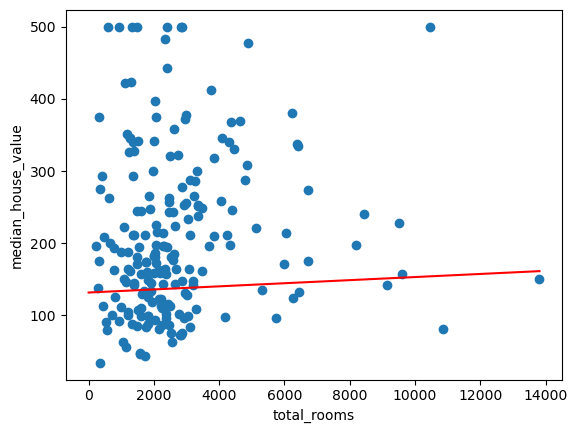

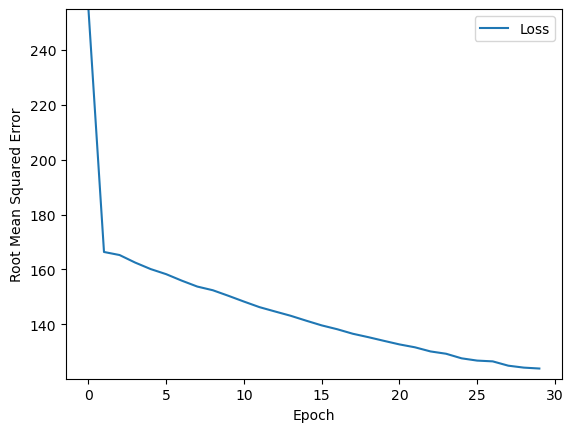

In [35]:
plot_the_model(weight, bias, my_feature,my_label)
plot_the_loss_curve(epochs,rmse)

# 모델을 이용해 추론하기

학습데이터와 테스트데이터로 분할하여 모델의 성능을 평가할 수 있다. 해당 exercise에서는 같은 학습데이터의 서브셋을 사용하도록 하였다.

In [41]:
def predict_house_values(n, feature, label):
    """feature기반으로 주택 가치 추정하기"""
    
    batch = training_df[feature][10000:10000+n]
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict_on_batch
    predicted_values = my_model.predict_on_batch(x=batch)
    
    print("feature   label          predicted")
    print("  value   value          value")
    print("          in thousand$   in thousand$")
    print("--------------------------------------")
    for i in range(n):
        print ("%5.0f %6.0f %15.0f" % (training_df[feature][10000 + i],
                                     training_df[label][10000 + i],
                                     predicted_values[i][0] ))

In [42]:
predict_house_values(10,my_feature,my_label)

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1286     53             184
 1867     92             206
 2191     69             219
 1052     62             175
 1647     80             198
 2312    295             223
 1604    500             196
 1066    342             176
  338    118             148
 1604    128             196


# Task 2 모델의 예측력 평가하기

위의 테이블에서 실제값과 예측값의 차이를 살펴보라.

대부분의 예측값들이 실제값 label value와 상당히 다른 것을 확인할 수 있다. 따라서 해당 모델의 좋은 예측력을 가지고 있다고 보기 어렵다. 이와같은 예측력은 처음 10개의 example이 10개 이외의 데이터에 대해 대표성을 가지고 있지 않기 때문일지도 모른다.

# Task 3 다른 feature 사용해보기

위에서 사용한 feature `'total_romms'`는 적은 예측력을 가지고 있는 것을 확인해보았다. 다른 feature을 사용하면 예측력이 높아질까? 


`population`을 feature로 모델을 구성해 예측해보자.

Epoch 1/18
5667/5667 [==============================] - 6s 1ms/step - loss: 14499.9785 - root_mean_squared_error: 120.4159
Epoch 2/18
5667/5667 [==============================] - 6s 1ms/step - loss: 14332.1650 - root_mean_squared_error: 119.7170
Epoch 3/18
5667/5667 [==============================] - 6s 1ms/step - loss: 14167.9482 - root_mean_squared_error: 119.0292
Epoch 4/18
5667/5667 [==============================] - 6s 1ms/step - loss: 14140.2773 - root_mean_squared_error: 118.9129
Epoch 5/18
5667/5667 [==============================] - 7s 1ms/step - loss: 14046.0469 - root_mean_squared_error: 118.5160
Epoch 6/18
5667/5667 [==============================] - 6s 1ms/step - loss: 14035.5459 - root_mean_squared_error: 118.4717
Epoch 7/18
5667/5667 [==============================] - 6s 1ms/step - loss: 14017.9619 - root_mean_squared_error: 118.3975
Epoch 8/18
5667/5667 [==============================] - 6s 1ms/step - loss: 13993.6865 - root_mean_squared_error: 118.2949
Epoch 9/18
5667/

C:\Users\Playdata\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


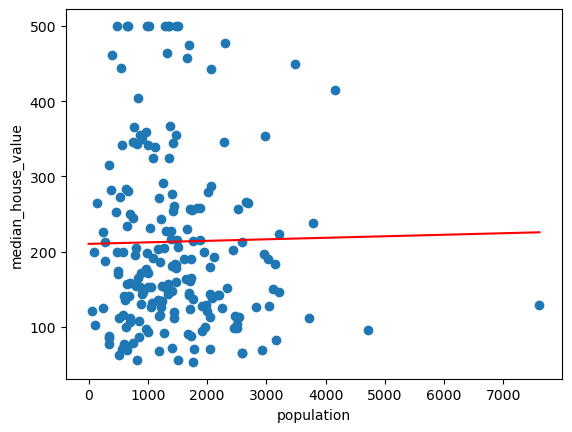

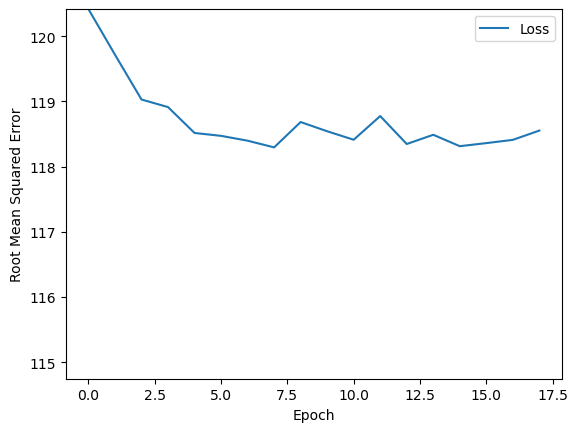

In [48]:
my_feature = 'population'

learning_rate = 0.05
epochs = 18
batch_size = 10

weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)
plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)


In [45]:
predict_house_values(15, my_feature, my_label)

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1286     53             173
 1867     92             186
 2191     69             194
 1052     62             167
 1647     80             181
 2312    295             197
 1604    500             180
 1066    342             168
  338    118             151
 1604    128             180
 1200    187             171
  292     80             150
 2014    112             190
 1817     95             185
 1328     69             174


#### Q. feature 값으로 `population`을 사용하는 모델이 `total_room`를 사용하는 것돠 더 나은 예측을 수행하는가?



확정적으로 말할 순 없지만 하이퍼 파라미터를 조정해보아도 대체적으로 population을 feature로 사용할 때 total_rooms를 사용할 때보다 다소 RMSE가 높게 형성되어 있는 것을 확인할 수 있다. 따라서 population은 비슷하거나 덜 나은 예측을 한다고 볼 수 있다.

# Task 4. synthetic feature 정의하기

`total_rooms`과 `population` 이 유용한 feature에 해당하지 않는 것을 확인했다. 이것은 전체 방 개수와 인구수가 주택가치의 중앙값 예측에 유용하지 않다는 것을 의미한다. 


 하지만, `population` 대비 `total_rooms` 비도 비슷한 예측력을 보일 수도 있다. 즉, 블록마다의 인구밀집도(density)가 주택가치의 중앙값과 연관있을 수 있다.
 
 
 1. synthetic feature(인구 대비 방의 개수)을 만든다
 2. 하이퍼 파라미터를 튜닝한다
 3. synthetic feature을 사용한 모델이 loss를 줄이는지 판단한다

Epoch 1/24
567/567 [==============================] - 1s 1ms/step - loss: 38103.4062 - root_mean_squared_error: 195.2009
Epoch 2/24
567/567 [==============================] - 0s 841us/step - loss: 19002.9902 - root_mean_squared_error: 137.8513
Epoch 3/24
567/567 [==============================] - 1s 949us/step - loss: 14945.6631 - root_mean_squared_error: 122.2525
Epoch 4/24
567/567 [==============================] - 1s 1ms/step - loss: 14815.4062 - root_mean_squared_error: 121.7186
Epoch 5/24
567/567 [==============================] - 1s 1ms/step - loss: 14659.3125 - root_mean_squared_error: 121.0756
Epoch 6/24
567/567 [==============================] - 1s 1ms/step - loss: 14495.6367 - root_mean_squared_error: 120.3978
Epoch 7/24
567/567 [==============================] - 1s 1ms/step - loss: 14354.8232 - root_mean_squared_error: 119.8116
Epoch 8/24
567/567 [==============================] - 1s 1ms/step - loss: 14197.5566 - root_mean_squared_error: 119.1535
Epoch 9/24
567/567 [========

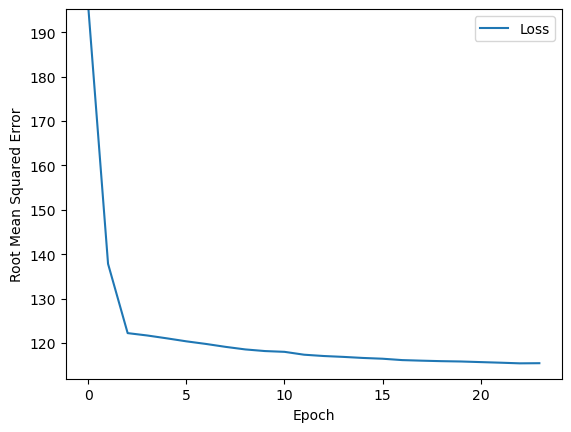

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    2     53             190
    2     92             201
    2     69             195
    2     62             211
    1     80             187
    2    295             225
    2    500             210
    2    342             223
    4    118             286
    2    128             214
    2    187             224
    3     80             234
    2    112             225
    2     95             219
    2     69             211


In [49]:
training_df["rooms_per_person"] = training_df["total_rooms"] / training_df["population"]
my_feature = "rooms_per_person"

# Tune the hyperparameters.
learning_rate = 0.06
epochs = 24
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, mae = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

plot_the_loss_curve(epochs, mae)
predict_house_values(15, my_feature, my_label)

loss values를 보면 synthetic feature를 사용하는게 각각 feature을 사용하는 것보다 더 나은 예측을 수행하는 것을 확인할 수 있다.(Task2, Task3) 다만 이 모델 역시 좋은 예측을 수행한다고 판단하기는 어렵다.

# Task 5. label과 상관관계가 있는 feature 찾기

correlation matrix를 확인하여 label과 feature의 상관 관계를 간단하게 확인할 수 있다.

In [50]:
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0,-0.1
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1,0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1,-0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0,-0.1
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1,-0.0
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7,0.2
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0,0.2
rooms_per_person,-0.1,0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,0.2,1.0
